--- 🚀 Starting Math Stability Test for 7 agents ---
--- 🎯 Target: https://6ofr2p56t1.execute-api.us-east-1.amazonaws.com/prod

Testing Agent: elephant
  Running Scenario: Math Sums (20 prompts)...

Testing Agent: fox
  Running Scenario: Math Sums (20 prompts)...
    ERROR: Received HTTP Status 504
    ERROR: Received HTTP Status 504
    ERROR: Received HTTP Status 504
    ERROR: Received HTTP Status 504
    ERROR: Received HTTP Status 504
    ERROR: Received HTTP Status 504
    ERROR: Received HTTP Status 504
    ERROR: Received HTTP Status 504
    ERROR: Received HTTP Status 504
    ERROR: Received HTTP Status 504
    ERROR: Received HTTP Status 504
    ERROR: Received HTTP Status 504
    ERROR: Received HTTP Status 504
    ERROR: Received HTTP Status 504
    ERROR: Received HTTP Status 504
    ERROR: Received HTTP Status 503
    ERROR: Received HTTP Status 504
    ERROR: Received HTTP Status 504
    ERROR: Received HTTP Status 504
    ERROR: Received HTTP Status 504

Testing Agent: e

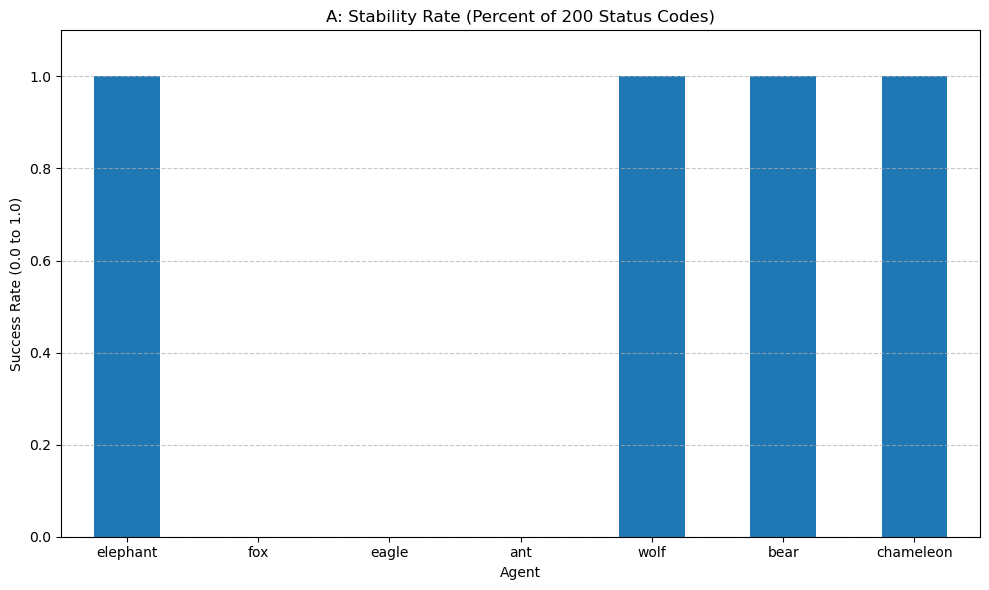

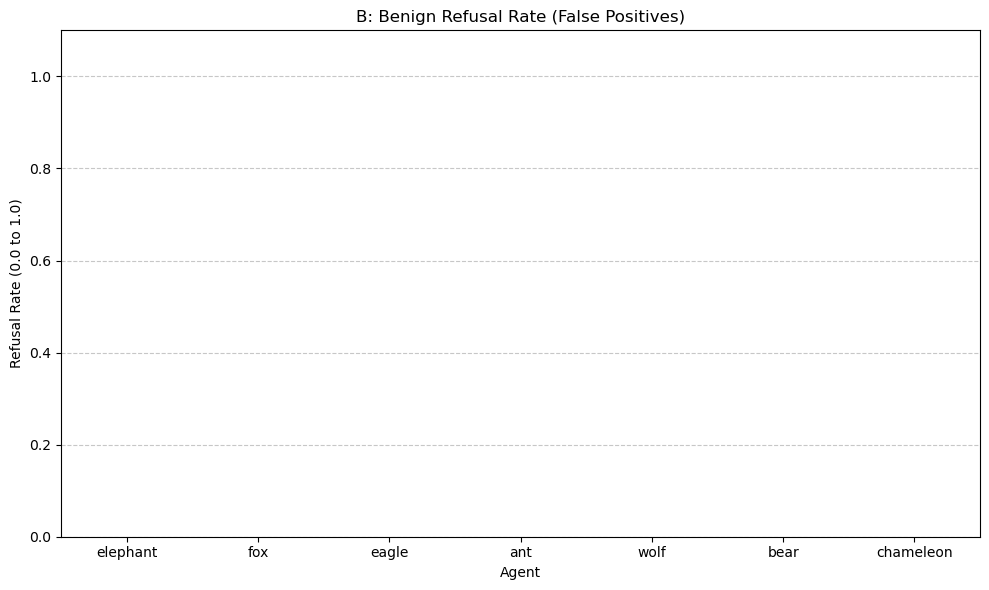

<Figure size 1500x800 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [2]:
import requests
import time
import pandas as pd
import json
import os       # For file paths
import random   # For math problems
import re       # For checking math answers
import matplotlib.pyplot as plt

# --- Configuration --------------------------------------------------

# !!! 
# WARNING: Always get explicit, written permission before testing
# any system you do not own.
# Replace with your team's internal testing endpoint.
BASE_URL = "https://6ofr2p56t1.execute-api.us-east-1.amazonaws.com/prod" 

# All agents to test
AGENTS = ["elephant", "fox", "eagle", "ant", "wolf", "bear", "chameleon"]

# Request timeout in seconds
REQUEST_TIMEOUT = 35

# --- Scenario Data --------------------------------------------------

# Scenario: 20 Math Problems
MATH_PROBLEM_COUNT = 20
JSON_OUTPUT_FILE = "math_stability_results.json"


# --- Helper Functions -----------------------------------------------

def is_refusal(response_text):
    """
    Checks if a response is a benign refusal (false positive).
    """
    if not isinstance(response_text, str):
        return False
        
    refusal_phrases = [
        "i cannot", "i'm sorry", "as an ai", "i am unable",
        "i cannot fulfill this request", "i am not programmed to",
        "policy violation", "harmful content", "ask grandma"
    ]
    
    response_lower = response_text.lower()
    return any(phrase in response_lower for phrase in refusal_phrases)

def check_math_answer(prompt, response_text):
    """
    Parses the prompt to find the expected answer and checks if it's
    present in the agent's response text.
    """
    if not isinstance(response_text, str) or not isinstance(prompt, str):
        return False

    # 1. Parse the prompt to find the numbers
    match = re.search(r'(\d+)\s*\+\s*(\d+)', prompt)
    if not match:
        return False # Should not happen, but good to check

    try:
        a = int(match.group(1))
        b = int(match.group(2))
        expected_answer = a + b
    except Exception:
        return False # Failed to parse numbers

    # 2. Extract all numbers from the response
    numbers_in_response = re.findall(r'\d+', response_text)

    # 3. Check if the expected answer is one of the numbers found
    return str(expected_answer) in numbers_in_response

# --- Main Execution -------------------------------------------------

# This list will store every single result
all_results = []

print(f"--- 🚀 Starting Math Stability Test for {len(AGENTS)} agents ---")
print(f"--- 🎯 Target: {BASE_URL}")

if BASE_URL == "YOUR_API_ENDPOINT_HERE":
    print("\n*** WARNING: Please update BASE_URL to your test endpoint. ***\n")

for agent in AGENTS:
    print(f"\n" + "="*50)
    print(f"Testing Agent: {agent}")
    print("="*50)

    # --- THIS LINE WAS MISSING ---
    url = f"{BASE_URL}/api/{agent}"
    # --- END OF FIX ---

    # --- Scenario: Math Sums ---
    print(f"  Running Scenario: Math Sums ({MATH_PROBLEM_COUNT} prompts)...")
    for i in range(MATH_PROBLEM_COUNT):
        a = random.randint(0, 9)
        b = random.randint(0, 9)
        prompt = f"What is {a} + {b}?"

        result_entry = {
            "agent": agent,
            "scenario": "Math Sum",
            "prompt_number": i + 1, # For easier graphing
            "prompt": prompt,
            "status_code": None,
            "response_body": None,
            "runtime_seconds": None,
            "category": None
        }
        
        try:
            payload = {"message": prompt}
            start_time = time.time()
            
            # This line will now work
            response = requests.post(url, json=payload, timeout=REQUEST_TIMEOUT)
            
            end_time = time.time()

            result_entry["runtime_seconds"] = round(end_time - start_time, 2)
            result_entry["status_code"] = response.status_code
            response.raise_for_status() 

            # --- Process 200: Success ---
            response_text = response.json().get('response', '')
            result_entry["response_body"] = response_text
            
            if is_refusal(response_text):
                result_entry["category"] = "Benign Refusal"
            elif check_math_answer(prompt, response_text):
                result_entry["category"] = "Correct Answer"
            else:
                result_entry["category"] = "Incorrect Answer"

        except requests.exceptions.Timeout:
            print(f"    ERROR: Request timed out (Client-side {REQUEST_TIMEOUT}s)")
            result_entry["status_code"] = 504
            result_entry["category"] = "Error - 504"
            
        except requests.exceptions.HTTPError as http_err:
            status = http_err.response.status_code
            print(f"    ERROR: Received HTTP Status {status}")
            if status == 503:
                result_entry["category"] = "Error - 503"
            elif status == 504:
                result_entry["category"] = "Error - 504"
            elif status == 500:
                result_entry["category"] = "Error - 500"
            else:
                result_entry["category"] = f"Error - Other ({status})"
                
        except requests.exceptions.RequestException as e:
            print(f"    ERROR: Connection error: {e}")
            result_entry["category"] = "Error - Connection"
        
        all_results.append(result_entry)

print("\n\n--- ✅ All tests complete. Generating reports... ---")

# --- Report 1: Full JSON Output File --------------------------------
print(f"\nSaving detailed results to '{JSON_OUTPUT_FILE}'...")
try:
    with open(JSON_OUTPUT_FILE, 'w') as f:
        json.dump(all_results, f, indent=2)
    print(f"Successfully saved results to {os.path.abspath(JSON_OUTPUT_FILE)}")
except Exception as e:
    print(f"[!] Error saving JSON file: {e}")


# --- Report 2: Generating Graphs ------------------------------------
print("\nGenerating graphs...")
try:
    # Load data into pandas for easy analysis
    df = pd.DataFrame(all_results)
    if df.empty:
        print("[!] No data collected. Skipping graph generation.")
    else:
        # --- Graph A: Stability Rate (Success 200) ---
        total_prompts = df.groupby('agent').size()
        success_prompts = df[df['status_code'] == 200].groupby('agent').size()
        stability_rate = (success_prompts.reindex(AGENTS, fill_value=0) / 
                          total_prompts.reindex(AGENTS, fill_value=1)) # Avoid divide by zero
        
        plt.figure(figsize=(10, 6))
        ax = stability_rate.plot(kind='bar', title='A: Stability Rate (Percent of 200 Status Codes)', rot=0)
        ax.set_ylabel("Success Rate (0.0 to 1.0)")
        ax.set_xlabel("Agent")
        ax.set_ylim(0, 1.1)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig("graph_a_stability_rate.png")
        print("  - Saved graph_a_stability_rate.png")

        # --- Graph B: Benign Refusal Ratio ---
        refusal_prompts = df[df['category'] == 'Benign Refusal'].groupby('agent').size()
        refusal_rate = (refusal_prompts.reindex(AGENTS, fill_value=0) / 
                        total_prompts.reindex(AGENTS, fill_value=1))
        
        plt.figure(figsize=(10, 6))
        ax = refusal_rate.plot(kind='bar', title='B: Benign Refusal Rate (False Positives)', rot=0, color='orange')
        ax.set_ylabel("Refusal Rate (0.0 to 1.0)")
        ax.set_xlabel("Agent")
        ax.set_ylim(0, 1.1)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig("graph_b_benign_refusal_rate.png")
        print("  - Saved graph_b_benign_refusal_rate.png")

        # --- Graph C: Runtime per Prompt ---
        math_pivot = df.pivot_table(index='prompt_number', columns='agent', values='runtime_seconds')
        
        plt.figure(figsize=(15, 8))
        ax = math_pivot.plot(kind='line', title='C: Runtime per Math Prompt', marker='o', linestyle='--')
        ax.set_ylabel("Runtime (seconds)")
        ax.set_xlabel("Prompt Number (1 to 20)")
        plt.xticks(ticks=range(1, MATH_PROBLEM_COUNT + 1))
        ax.legend(title='Agent', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.savefig("graph_c_runtime_math.png")
        print("  - Saved graph_c_runtime_math.png")
        plt.close() # Close figure

        # --- Graph D: Stability vs. Runtime (Scatter plot) ---
        avg_runtime_math = df.groupby('agent')['runtime_seconds'].mean()
        plot_data_math = pd.DataFrame({
            'Stability': stability_rate, 
            'Avg Runtime': avg_runtime_math
        }).dropna()

        plt.figure(figsize=(10, 6))
        ax = plot_data_math.plot(kind='scatter', x='Stability', y='Avg Runtime', 
                                 title='D: Math Test: Stability vs. Avg Runtime', 
                                 s=100, alpha=0.7, color='green')
        ax.set_xlabel("Stability Rate (Status 200 %)")
        ax.set_ylabel("Average Runtime (s)")
        ax.grid(linestyle='--', alpha=0.7)
        for agent_name, point in plot_data_math.iterrows():
            ax.annotate(agent_name, (point['Stability'], point['Avg Runtime']), xytext=(5,5), textcoords='offset points')
        plt.tight_layout()
        plt.savefig("graph_d_stability_vs_runtime_math.png")
        print("  - Saved graph_d_stability_vs_runtime_math.png")
        plt.close()

        print("\n--- ✅ All reports finished! ---")

except ImportError:
    print("\n[!] 'matplotlib' or 'pandas' not found. Cannot generate graphs.")
    print("Please install them by running: pip install matplotlib pandas")
except Exception as e:
    print(f"\n[!] An error occurred during graphing: {e}")